In [1]:
from os import listdir
from sklearn.model_selection import train_test_split
from glob import glob
from imblearn.over_sampling import RandomOverSampler
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Dropout
from keras.models import Model
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import pandas as pd
import numpy as np
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [2]:
from keras import backend as K
K.clear_session()

# Índice 
1. Cargar los datos
2. Constucción del modelo base

# 1. Cargar los datos

Se procede a leer los archivos csv generados en el notebook **breast_cancer_Data.ipynb**.

In [3]:
train_path = "train_data.csv"
test_path = "test_data.csv"
val_path = "val_data.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
val_data = pd.read_csv(val_path)

train_data['label'] = train_data['label'].astype('str')
val_data['label'] = val_data['label'].astype('str')
test_data['label'] = test_data['label'].astype('str')

Como el conjunto de imágenes es muy grande, no es factible entrenar el modelo cargando todo el conjunto en RAM. Para ello, se proceden a cargar los conjuntos de datos en **batch**. Es decir, durante el entrenamiento se irán generando batch de imágenes. Para realizar esto, hemos usado el módul de tensorflow de **ImageDataGenerator**, donde hemos aprovechado para realizado unas transformaciones a las imagenes generadas: 

Para el conjunto train:
* En primer lugar se escalan las imágenes dividiendo por 255.
* Las redes CNN (convolucionales), son muy sensibles a las rotaciones pero no a la traslaciones. Por ello, se realizan rotaciones aleatorias.

Para el conjunto validation y test:
* Se escalan las imágenes dividiendo por 255.

In [4]:
datagen_train = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=25)

batch_size = 32


train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_data,
    x_col='path', 
    y_col='label',
    target_size=(50, 50),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42,
    validate_filenames=False
)

datagen_test = ImageDataGenerator(rescale=1./255)

val_generator = datagen_test.flow_from_dataframe(
    dataframe=val_data,
    x_col='path', 
    y_col='label',
    target_size=(50, 50),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42,
    validate_filenames=False
)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_data,
    x_col='path', 
    y_col='label',
    target_size=(50, 50),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42,
    validate_filenames=False
)

train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
test_steps_per_epoch = test_generator.n // test_generator.batch_size

Found 194266 non-validated image filenames belonging to 2 classes.
Found 41629 non-validated image filenames belonging to 2 classes.
Found 41629 non-validated image filenames belonging to 2 classes.


# 2. Construcción del modelo base

Antes de construir modelos complejos, vamos a desarrollar un modelo base como punto de referencia, con el fin de obtener retroalimentación y evaluar si estamos siguiendo la dirección correcta o no. A continuación se detallan algunas decisiones tomadas respecto a su diseño:

**Métrica**: como métrica para evaluar el rendimiento del modelo, hemos optado por la **f1_score**. Al ser un conjunto de datos desbalanceados, la métrica simple como el **Accuracy**, puede no ser fiable ya que podría ser alto pero no reflejar la situación real. Al usar la métrica de f1_score, estamos usando la media armónica entre la **precisión** (evalúa la tasa de falsos positivos) y el **recall** (evalúa la tasa de falsos negativos), siendo especial importante este último para este problema.

**Función de pérdida**: como ya se ha mencionado en el notebook **breast_cancer_Data.ipynb**, no se van a usar técicas de re-sampling o de generación de muestras sintéticas. Por ello, se busca usar técnicas que penalicen al modelo, por tanto, que penalicen la función de coste. La función de coste a usar es la típica de clasificación binaria, la **entropía cruzada binaria**, pero en este caso, ponderada por pesos asignado a cada clase. Los pesos que se les va a asignar a cada clase son calculados por el método **compute_class_weight** de sklearn. Este método, calcula la proporción de una clase respecto a la otra, así, la clase minoritaria tendrá un peso alto (pues la proporción de la clase mayoritaria respecto a la minoritaria es alta). Asignar un peso alto a la clase minoritaria hará que el modelo preste mas atención a esta clase a cambio de perder precisión en la clase mayoritaria.
$$
L = -\sum_{n=1}^{N}\sum_{k=1}^{K=2} w_{nk} \cdot y_{nk} \cdot \log(\hat{y_{nk}})
$$


Donde:

* $N$ es el número total de ejemplos en el conjunto de datos.
* $K$: Es el número de clases en el problema de clasificación. Para la clasificación binaria, 
* $y_i$ es el valor real (etiqueta) del ejemplo i.
* $\hat{y_i}$ es el valor predicho por el modelo para el ejemplo i.
* $w_i$ es el peso asociado al ejemplo i. Este peso puede utilizarse para dar mayor importancia a ciertos ejemplos durante el cálculo de la pérdida.


In [5]:
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    predicted_positives = K.sum(K.cast(y_pred, 'float'), axis=0)
    possible_positives = K.sum(K.cast(y_true, 'float'), axis=0)
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)

In [6]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
weights = {i : weights[i] for i in range(2)}
weights

{0: 0.69821587739728, 1: 1.7612511332728922}

## 2.1 CNN simple

In [7]:
def make_model_1():
    input_layer = Input(shape=(50,50,3))
    conv_layer_1 = Conv2D(filters=32, kernel_size=3, activation="relu")(input_layer)
    pool_1 = MaxPooling2D(pool_size=2)(conv_layer_1)
    conv_layer_2 = Conv2D(filters=64, kernel_size=3, activation="relu")(pool_1)
    pool_2 = MaxPooling2D(pool_size=2)(conv_layer_2)
    flatten = Flatten()(pool_2)
    dense_2 = Dense(64, activation="relu")(flatten)
    output_layer = Dense(1, activation='sigmoid')(dense_2)

    model = Model(inputs=input_layer,outputs=output_layer)
    print(model.summary())
    return model

In [8]:
model_1 = make_model_1()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0     

Características:
* Un modelo simple, sin capas de regularización. Consta de **515.137** parámetros. 
* Para el entrenamiento, se ha escogido el optimizador **Adam**, por ser ampliamente usado ya que es un optimizador adaptativo con momentum. 
* El learning rate establecido, es por defecto, **0.001**.
* Se usa **Early stopping** para que pare el entrenamiento si no mejora en 20 épocas.
* Se usa **checkpoints** para ir guardando durante el entrenamiento, el mejor modelo.

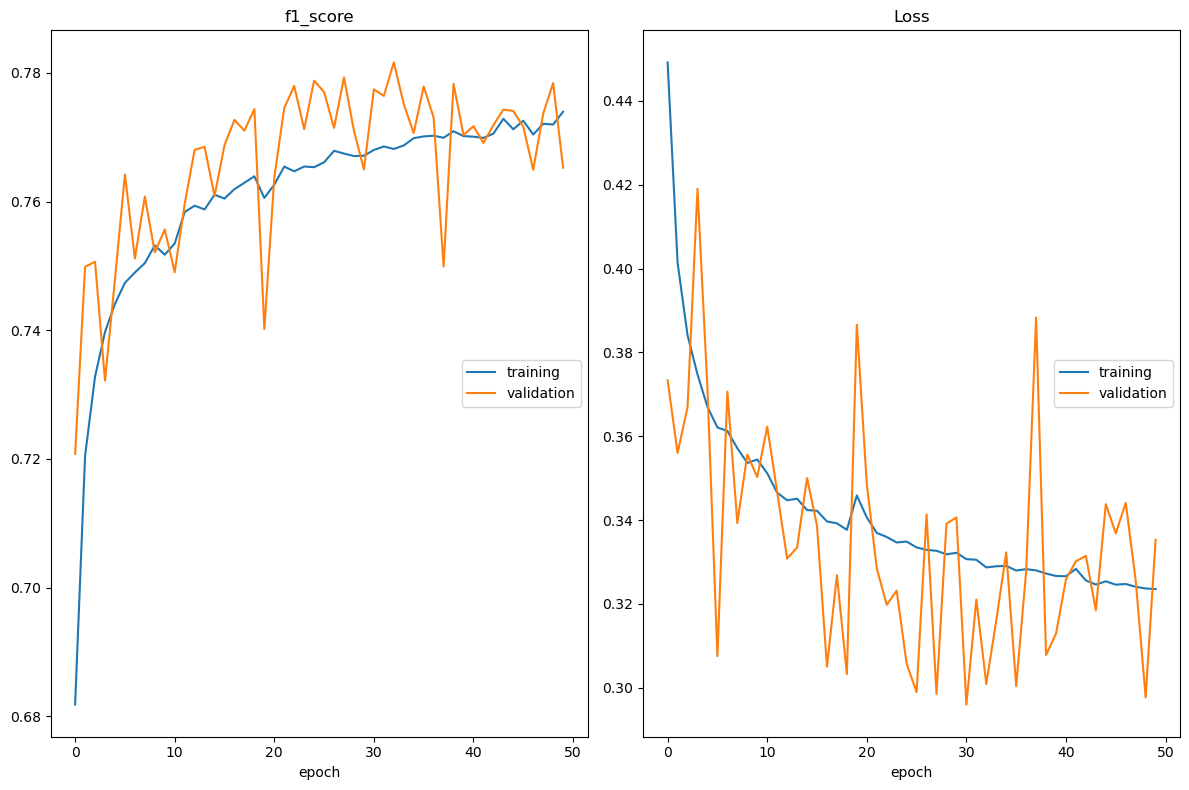

f1_score
	training         	 (min:    0.682, max:    0.774, cur:    0.774)
	validation       	 (min:    0.721, max:    0.782, cur:    0.765)
Loss
	training         	 (min:    0.324, max:    0.449, cur:    0.324)
	validation       	 (min:    0.296, max:    0.419, cur:    0.335)

Epoch 50: val_loss did not improve from 0.29595
6070/6070 [==============================] - 344s 57ms/step - loss: 0.3235 - f1_score: 0.7740 - val_loss: 0.3353 - val_f1_score: 0.7653


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, min_delta=0.001)

checkpoint_path = 'model_1_v1.h5'

# Crear un objeto ModelCheckpoint
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss',  # Métrica a monitorear para determinar el mejor modelo
                             verbose=1,  # Verbosidad (mostrar información adicional)
                             save_best_only=True,  # Guardar solo el mejor modelo
                             save_weights_only=False,  # Guardar los pesos y arquitectura del modelo completo
                             mode='min'  # Modo de selección del mejor modelo (min o max)
                            )

model_1.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=[f1_score]) 

model_1 = model_1.fit(
            train_generator,
            steps_per_epoch=train_steps_per_epoch,
            validation_data=val_generator,
            validation_steps=val_steps_per_epoch,
            epochs=50,
            callbacks=[PlotLossesKeras(), early_stopping, checkpoint],
            class_weight=weights
         )

## 2.2 CNN simple versión 2

A continuación, se va a construir un modelo cuya arquitectura (primeras capas) está inspirada en la arquitectura de **AlexNet**.

In [7]:
#AlexNet
def make_model_1_v2():
    input_layer = Input(shape=(50,50,3))
    x = Conv2D(filters=32, kernel_size=11, activation="relu", padding="same")(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = BatchNormalization()(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer,outputs=output_layer)
    print(model.summary())
    return model

In [8]:
model_1_v2 = make_model_1_v2()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 32)        11648     
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 64)       256   

Características:
* Modelo de **446.209** parámetros. La reducción cosiderable de parámetros a pesar de que el modelo es más profundo, se debe a las capas **maxpooling**.
* Capas de **Batch Normalization** para regularización. Estas capas normalizan la salida de las neuronas, lo que hace que el entrenamiento sea más estable además de añadir mas ruido (al normalizar las salidas), evitando el sobreajuste.


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, min_delta=0.001)

checkpoint_path = 'model_1_v2.h5'

# Crear un objeto ModelCheckpoint
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss',
                             verbose=1,  
                             save_best_only=True,  
                             save_weights_only=False, 
                             mode='min' 
                            )

model_1_v2.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=[f1_score]) 

model_1_v2 = model_1_v2.fit(
                train_generator,
                steps_per_epoch=train_steps_per_epoch,
                validation_data=val_generator,
                validation_steps=val_steps_per_epoch,
                epochs=50,
                callbacks=[early_stopping, checkpoint],
                class_weight=weights,
                verbose=1
             )

Epoch 1/50
6070/6070 [==============================] - ETA: 0s - loss: 0.4095 - f1_score: 0.7132
Epoch 1: val_loss improved from inf to 0.87472, saving model to model_1_v2.h5
6070/6070 [==============================] - 567s 92ms/step - loss: 0.4095 - f1_score: 0.7132 - val_loss: 0.8747 - val_f1_score: 0.2907
Epoch 2/50
6069/6070 [============================>.] - ETA: 0s - loss: 0.3822 - f1_score: 0.7308
Epoch 2: val_loss improved from 0.87472 to 0.37336, saving model to model_1_v2.h5
6070/6070 [==============================] - 351s 58ms/step - loss: 0.3823 - f1_score: 0.7309 - val_loss: 0.3734 - val_f1_score: 0.7408
Epoch 3/50
6070/6070 [==============================] - ETA: 0s - loss: 0.3688 - f1_score: 0.7417
Epoch 3: val_loss did not improve from 0.37336
6070/6070 [==============================] - 329s 54ms/step - loss: 0.3688 - f1_score: 0.7417 - val_loss: 0.4067 - val_f1_score: 0.6100
Epoch 4/50
6070/6070 [==============================] - ETA: 0s - loss: 0.3573 - f1_score: 

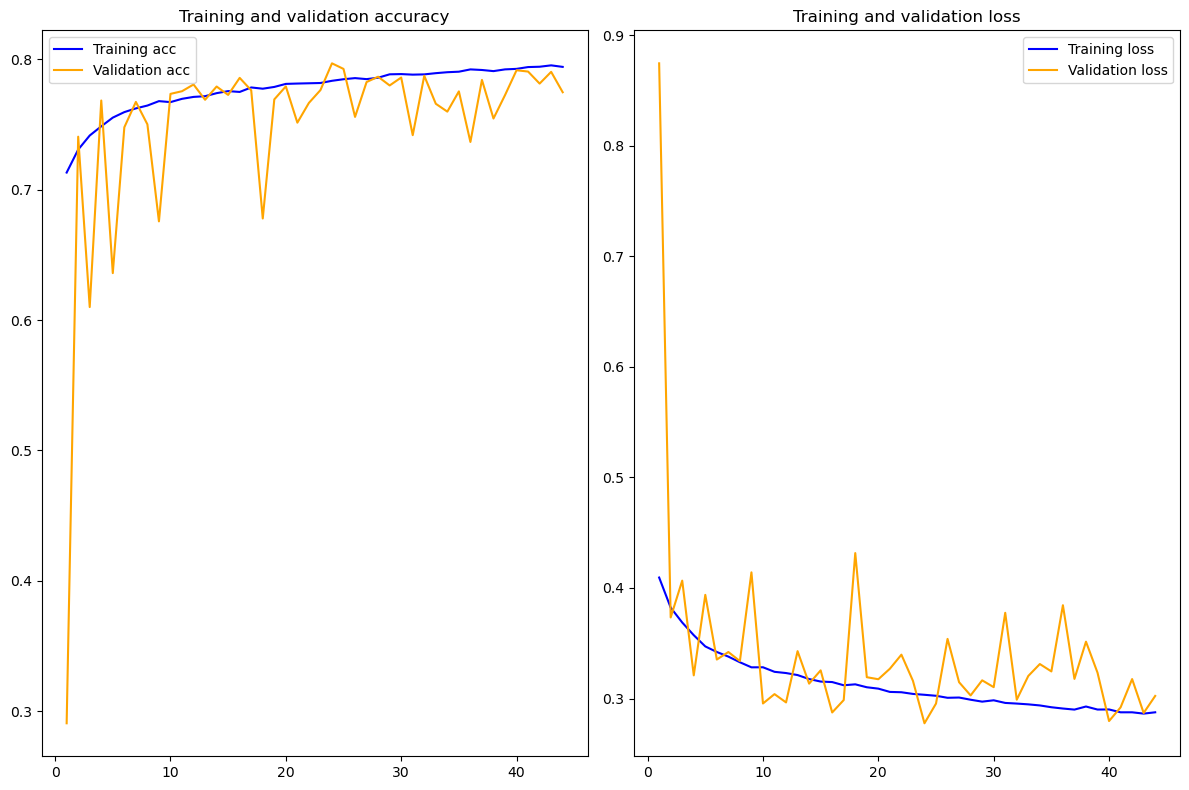

In [31]:
acc = model_1_v2.history['f1_score']
val_acc = model_1_v2.history['val_f1_score']
loss = model_1_v2.history['loss']
val_loss = model_1_v2.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

epochs = range(1, len(acc) + 1)

ax1.plot(epochs, acc, 'blue', label='Training acc')
ax1.plot(epochs, val_acc, 'orange', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'blue', label='Training loss')
ax2.plot(epochs, val_loss, 'orange', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

plt.tight_layout()

# Mostrar la figura
plt.show()

# 3. Predicciones aleatorias

Se cargan los modelos v1 y v2 entrenados

In [20]:
model_1_v1 = load_model('models/model_1_v1.h5', custom_objects={"f1_score": f1_score})
model_1_v2 = load_model('models/model_1_v2.h5', custom_objects={"f1_score": f1_score})

Se genera una muestra aleatoria del conjunto de validación. Val_generator genera un batch de 32 muestras, por tanto, escogemos la primera muestra para esta prueba:

In [21]:
x_batch, y_batch = next(val_generator)
x_random, y_random = x_batch[0], y_batch[0]
x_random = np.expand_dims(x_random, axis=0) #Expandir la dimensión, ya que el input a la red es: (1,50,50,3)
print(f"Etiqueta de la muestra aleatoria: {y_random}")

Etiqueta de la muestra aleatoria: 1.0


Obtenemos la predicción de los modelos

In [22]:
predictions_v1 = model_1_v1.predict(x_random)[0][0]
predictions_v2 = model_1_v2.predict(x_random)[0][0]

print("===========================================================================")
print(f"La predicción del modelo CNN_v1 es: {round(predictions_v1)}")
print(f"La predicción del modelo CNN_v2 es: {round(predictions_v2)}")
print("===========================================================================")
print(f"Probabilidad de CNN_v1: {predictions_v1}")
print(f"Probabilidad de CNN_v2: {predictions_v2}")

1/1 [==============================] - 0s 192ms/step
La predicción del modelo CNN_v1 es: 0
La predicción del modelo CNN_v2 es: 1
Probabilidad de CNN_v1: 0.38661256432533264
Probabilidad de CNN_v2: 0.6109785437583923


# 4. Transfer learning de la arquitectura ResNet

Viendo los resultados anteriores, es complicado mejorar el rendimiento construyendo un modelo desde cero. Por ello, vamos a estudiar y comparar los resultados con un modelo que ha sido entrenado para otras tareas, pero en un conjunto de datos muy grande, como es el caso de ResNet. 

![Arquitectura ResNet50](images/resnet-architecture.png)

ResNet es un tipo de arquitectura muy especial, llamada *"Redes residuales*". La idea principal que hay detrás de estas redes, es que las neuronas no solo van a aprender las conexiones de la capa anterior, sino que van a ir saltando algunas capas y conectarse a capas más adelante de la red (**bloques residuales**). Estos bloques permiten que la red aprenda una transformación progresiva en lugar de aprender una transformación completa. De esta forma se solucionan los problemas que tienen las redes neuronales profundas: el **desvanecimiento del gradiente** o **explosión del gradiente** y el **sobreajuste**.

![Bloques residuales](images/block__residual.png)

Introducida la arquitectura ResNet, se va a re-entrenar la **ResNet50**. Esta versión tiene 50 capas en total, lo que facilita el tiempo de entrenamiento. A pesar de ser una versión simple, ha demostrado lograr un rendimiento sólido en una variedad de tareas. Esta red, ha sido entrenada originalmente con el dataset **ImageNet**. Aunque este dataset es muy diferente al nuestro, pues contiene imágenes de diferentes categorías como perros, gatos, edificios, personas, etc. sirve para nuestro caso de uso, pues la red ya ha aprendido características comunes y básicas como bordes, textura, formas simples, etc.

Vamos a cargar el modelo con los pesos de las capas entrenados. No se incluye la capas densas superiores (**include_top**) para ajustar la res a nuestro problema. Por otro lado, se congenlan el resto de capas ya que no queremos entrenarlas, si fuese necesario descongelaríamos algunas de ellas para entrenarlas y hacer un **ajuste fino** (**fine-tuning**)

In [15]:
res_net_50 = ResNet50(weights=None, include_top=False, input_shape=(50, 50, 3))

weights_path = "models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

res_net_50.load_weights(weights_path)


In [41]:
for layer in res_net_50.layers:
    layer.trainable = False

Se crean las capas superiores de la red para ajustar la salida.

In [7]:
def transfer_learning_resNet(resNet_inputs, resNet_outputs):
    x = Flatten()(resNet_outputs)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=resNet_inputs,outputs=output)
    print(model.summary())
    return model

In [36]:
model_resNet = transfer_learning_resNet(res_net_50.input, res_net_50.output)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

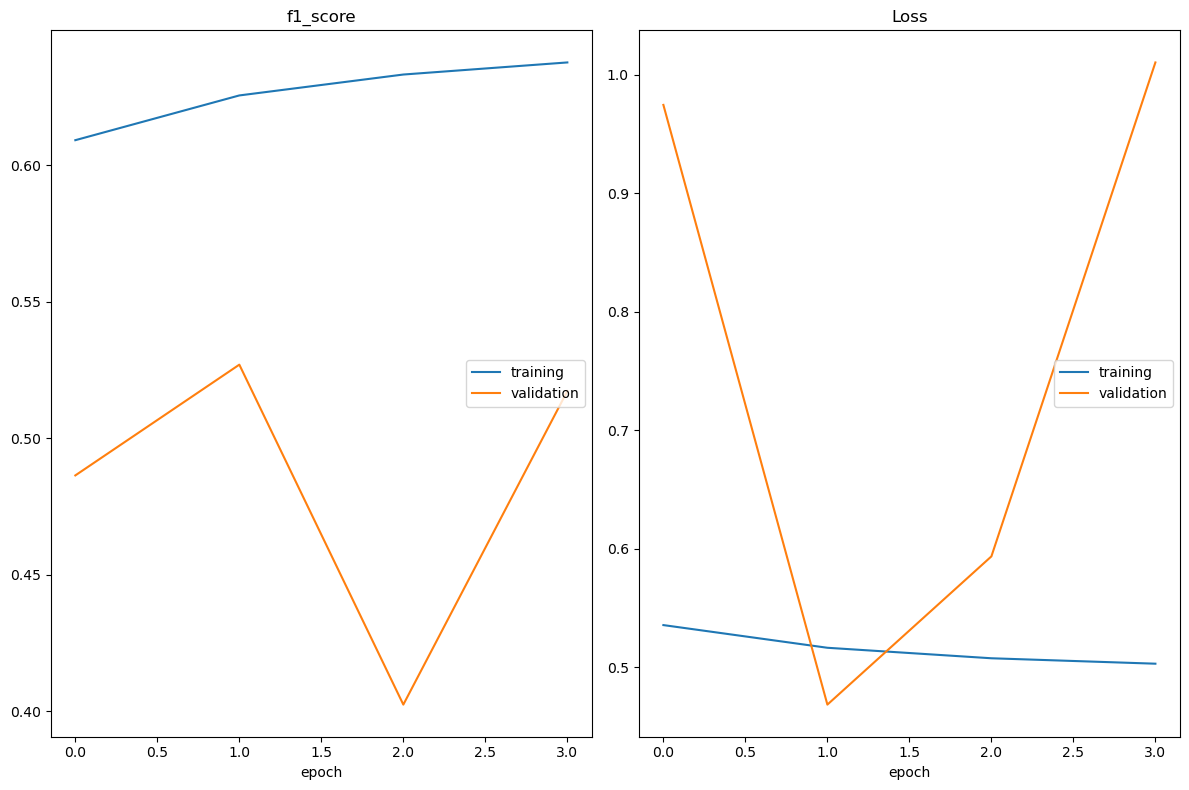

f1_score
	training         	 (min:    0.609, max:    0.638, cur:    0.638)
	validation       	 (min:    0.402, max:    0.527, cur:    0.517)
Loss
	training         	 (min:    0.503, max:    0.536, cur:    0.503)
	validation       	 (min:    0.468, max:    1.010, cur:    1.010)

Epoch 4: val_loss did not improve from 0.46839
6070/6070 [==============================] - 349s 58ms/step - loss: 0.5029 - f1_score: 0.6376 - val_loss: 1.0104 - val_f1_score: 0.5173
Epoch 5/10
 590/6070 [=>............................] - ETA: 4:17 - loss: 0.5062 - f1_score: 0.6309

KeyboardInterrupt: 

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=0.001)

checkpoint_path = 'model_resNet_bc.h5'

# Crear un objeto ModelCheckpoint
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss',  # Métrica a monitorear para determinar el mejor modelo
                             verbose=1,  # Verbosidad (mostrar información adicional)
                             save_best_only=True,  # Guardar solo el mejor modelo
                             save_weights_only=False,  # Guardar los pesos y arquitectura del modelo completo
                             mode='min'  # Modo de selección del mejor modelo (min o max)
                            )

model_resNet.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=[f1_score]) 

model_resNet = model_resNet.fit(
                train_generator,
                steps_per_epoch=train_steps_per_epoch,
                validation_data=val_generator,
                validation_steps=val_steps_per_epoch,
                epochs=10,
                callbacks=[PlotLossesKeras(), early_stopping, checkpoint],
                class_weight=weights
             )

Se ha parado el entrenamiento ya que, en la época 5 el rendimiento es muy pobre. Para ello, vamos a entrenar todas las capas de ResNet para adaptarla a nuestro problema. De esta forma, en vez de inicializar los pesos aleatoriamente, se van a inicializar por los pesos ya aprendidos de ImageNet. Por tanto, vamos a realizar **fine-tuning**.

In [8]:
res_net_50 = ResNet50(weights=None, include_top=False, input_shape=(50, 50, 3))

weights_path = "models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

res_net_50.load_weights(weights_path)

for layer in res_net_50.layers:
    layer.trainable = True
    
model_resNet = transfer_learning_resNet(res_net_50.input, res_net_50.output)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

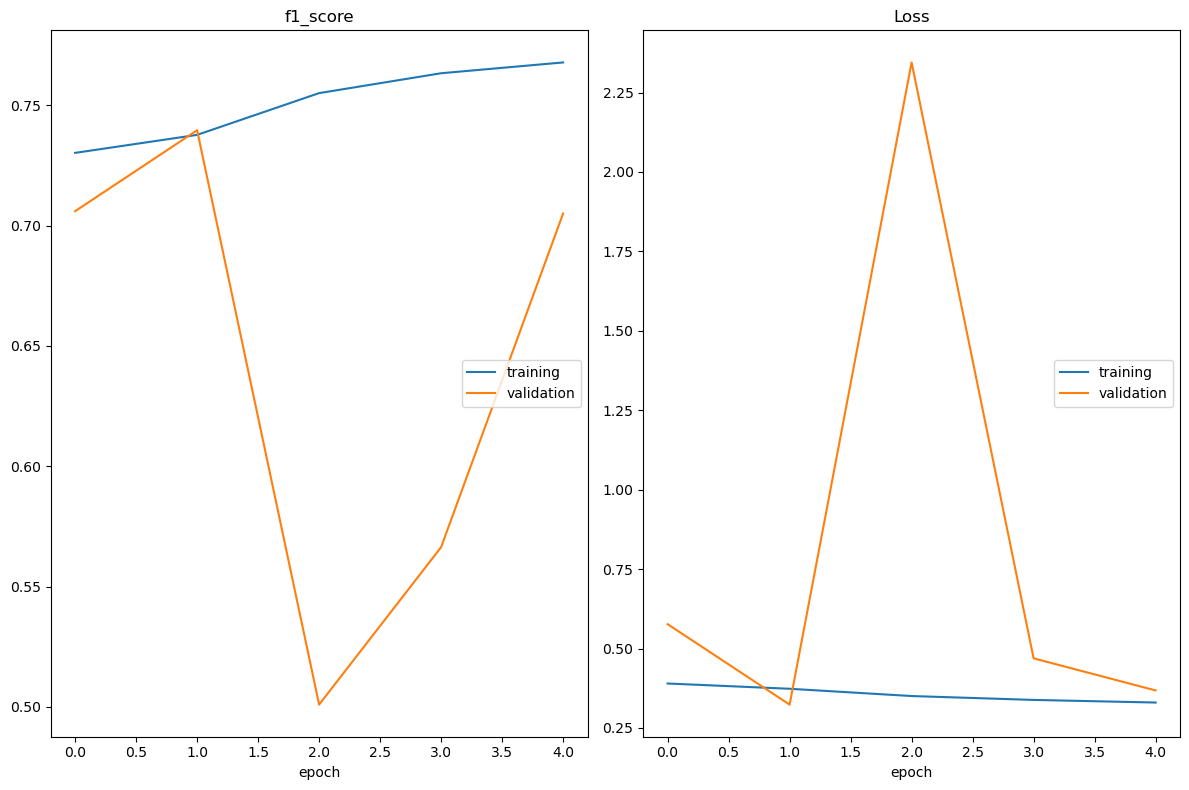

f1_score
	training         	 (min:    0.730, max:    0.768, cur:    0.768)
	validation       	 (min:    0.501, max:    0.740, cur:    0.705)
Loss
	training         	 (min:    0.330, max:    0.390, cur:    0.330)
	validation       	 (min:    0.323, max:    2.345, cur:    0.368)

Epoch 5: val_loss did not improve from 0.32346
6070/6070 [==============================] - 360s 59ms/step - loss: 0.3300 - f1_score: 0.7678 - val_loss: 0.3681 - val_f1_score: 0.7050
Epoch 6/50
6069/6070 [============================>.] - ETA: 0s - loss: 0.3240 - f1_score: 0.7707

KeyboardInterrupt: 

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, min_delta=0.001)

checkpoint_path = 'model_resNet_ft_bc_v2.h5'

# Crear un objeto ModelCheckpoint
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss',  # Métrica a monitorear para determinar el mejor modelo
                             verbose=1,  # Verbosidad (mostrar información adicional)
                             save_best_only=True,  # Guardar solo el mejor modelo
                             save_weights_only=False,  # Guardar los pesos y arquitectura del modelo completo
                             mode='min'  # Modo de selección del mejor modelo (min o max)
                            )

model_resNet.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=[f1_score]) 

model_resNet = model_resNet.fit(
                train_generator,
                steps_per_epoch=train_steps_per_epoch,
                validation_data=val_generator,
                validation_steps=val_steps_per_epoch,
                epochs=50,
                callbacks=[PlotLossesKeras(), early_stopping, checkpoint],
                class_weight=weights
             )

In [32]:
res_net_50 = ResNet50(weights=None, include_top=False, input_shape=(50, 50, 3))

weights_path = "models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

res_net_50.load_weights(weights_path)

for layer in res_net_50.layers:
    layer.trainable = True
    
model_resNet = transfer_learning_resNet(res_net_50.input, res_net_50.output)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

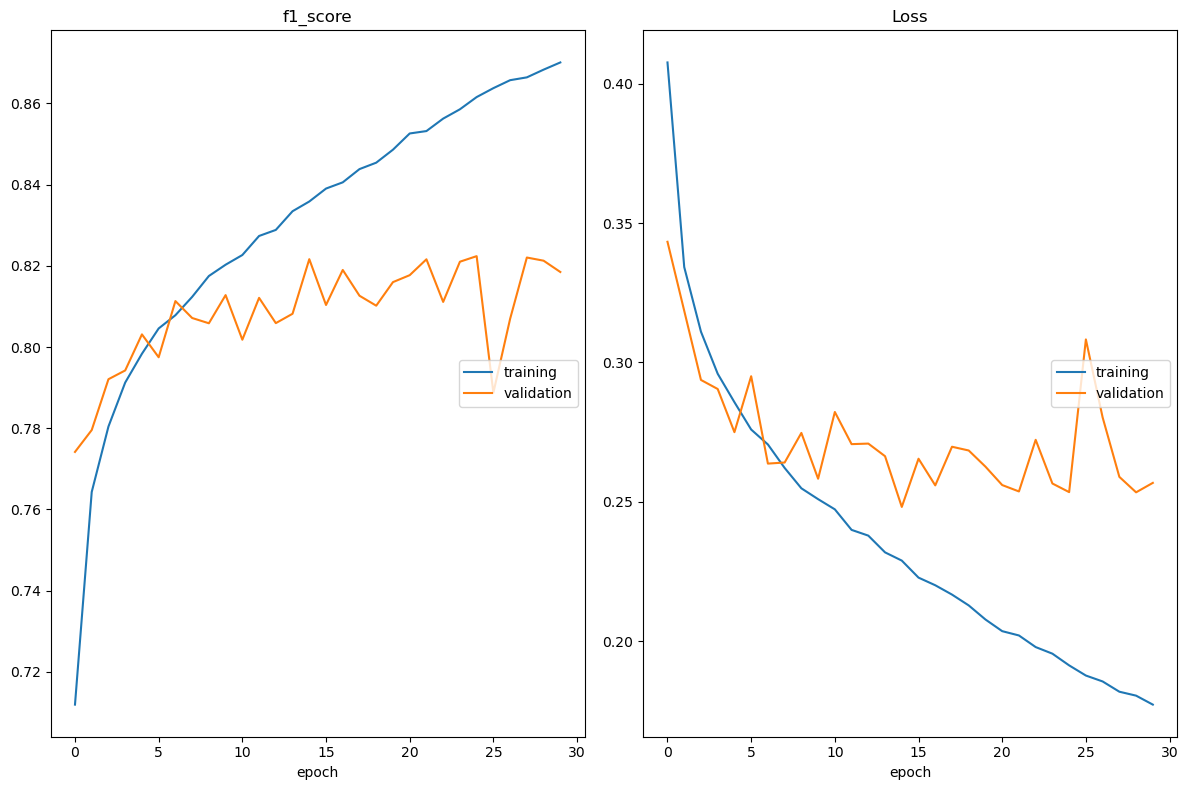

f1_score
	training         	 (min:    0.712, max:    0.870, cur:    0.870)
	validation       	 (min:    0.774, max:    0.822, cur:    0.818)
Loss
	training         	 (min:    0.177, max:    0.408, cur:    0.177)
	validation       	 (min:    0.248, max:    0.343, cur:    0.257)

Epoch 30: val_loss did not improve from 0.24814
6070/6070 [==============================] - 366s 60ms/step - loss: 0.1772 - f1_score: 0.8701 - val_loss: 0.2568 - val_f1_score: 0.8185
Epoch 30: early stopping


In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, min_delta=0.01)

checkpoint_path = 'model_resNet_ft_bc.h5'

# Crear un objeto ModelCheckpoint
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss',  # Métrica a monitorear para determinar el mejor modelo
                             verbose=1,  # Verbosidad (mostrar información adicional)
                             save_best_only=True,  # Guardar solo el mejor modelo
                             save_weights_only=False,  # Guardar los pesos y arquitectura del modelo completo
                             mode='min'  # Modo de selección del mejor modelo (min o max)
                            )

model_resNet.compile(optimizer=Adam(2e-5), loss='binary_crossentropy', metrics=[f1_score]) 

model_resNet = model_resNet.fit(
                train_generator,
                steps_per_epoch=train_steps_per_epoch,
                validation_data=val_generator,
                validation_steps=val_steps_per_epoch,
                epochs=150,
                callbacks=[PlotLossesKeras(), early_stopping, checkpoint],
                class_weight=weights
             )

# 5. Comparación de modelos

En esta sección, se va a estudiar en profundidad, qué modelo ofrece mejor rendimiento entre todos los entrenados usando el conjunto de datos de **test**. En primer lugar, se procede a cargar los modelos a comparar.

In [34]:
#svm =
model_1_v1 = load_model('models/model_1_v1.h5', custom_objects={"f1_score": f1_score})
model_1_v2 = load_model('models/model_1_v2.h5', custom_objects={"f1_score": f1_score})
model_resNet = load_model('model_resNet_ft_bc.h5', custom_objects={"f1_score": f1_score})

Se obtienen las etiquetas verdaderas del conjunto de test

In [35]:
y_true = test_generator.labels

Obtenemos las predicciones de cada modelo

In [36]:
#y_predict_svm = np.round(model_1_v1.predict(test_generator))
y_predict_model_1_v1 = model_1_v1.predict(test_generator)
y_predict_model_1_v2 = model_1_v2.predict(test_generator)
y_predict_model_resNet = model_resNet.predict(test_generator)

1301/1301 [==============================] - 29s 22ms/step


## 5.1 Precision-recall curva (AUC)

La primera comparación es la curva AUC. Esta métrica va a medir el desempeño del modelo en distintos umbrales, así podemos ver como se comporta los distintos modelos en distintas situaciones (distintos **threshold**), Lo idóneo es conseguir una curva lo más proximo a 1, pues supondría una precisión y un recall perfecto.

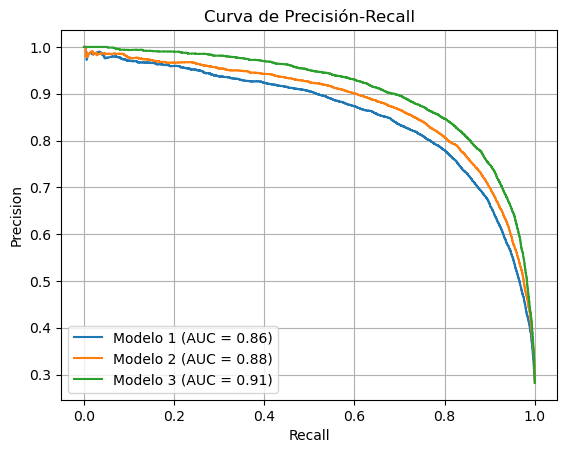

In [37]:
precision_model1, recall_model1, _ = precision_recall_curve(y_true, y_predict_model_1_v1)
precision_model2, recall_model2, _ = precision_recall_curve(y_true, y_predict_model_1_v2)
precision_model3, recall_model3, _ = precision_recall_curve(y_true, y_predict_model_resNet)

auc_model1 = average_precision_score(y_true, y_predict_model_1_v1, average="weighted")
auc_model2 = average_precision_score(y_true, y_predict_model_1_v2, average="weighted")
auc_model3 = average_precision_score(y_true, y_predict_model_resNet, average="weighted")

plt.plot(recall_model1, precision_model1, label='Modelo 1 (AUC = {:.2f})'.format(auc_model1))
plt.plot(recall_model2, precision_model2, label='Modelo 2 (AUC = {:.2f})'.format(auc_model2))
plt.plot(recall_model3, precision_model3, label='Modelo 3 (AUC = {:.2f})'.format(auc_model3))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precisión-Recall')
plt.legend()
plt.grid(True)
plt.show()

## 5.2 Matriz de confusión

En primer lugar, vamos a transformar los valores predichos por los modelos, en 1 y 0. Ya que la salida es la activación sigmoide, esta nos da la probabilidad y no el valor absoluto.

In [38]:
#y_predict_svm = np.round(model_1_v1.predict(test_generator))
y_predict_model_1_v1_abs = np.round(y_predict_model_1_v1)
y_predict_model_1_v2_abs = np.round(y_predict_model_1_v2)
y_predict_model_resNet_abs = np.round(y_predict_model_resNet)

In [39]:
cm_model1 = confusion_matrix(y_true, y_predict_model_1_v1_abs, normalize="true")
cm_model2 = confusion_matrix(y_true, y_predict_model_1_v2_abs, normalize="true")
cm_model3 = confusion_matrix(y_true, y_predict_model_resNet_abs, normalize="true")

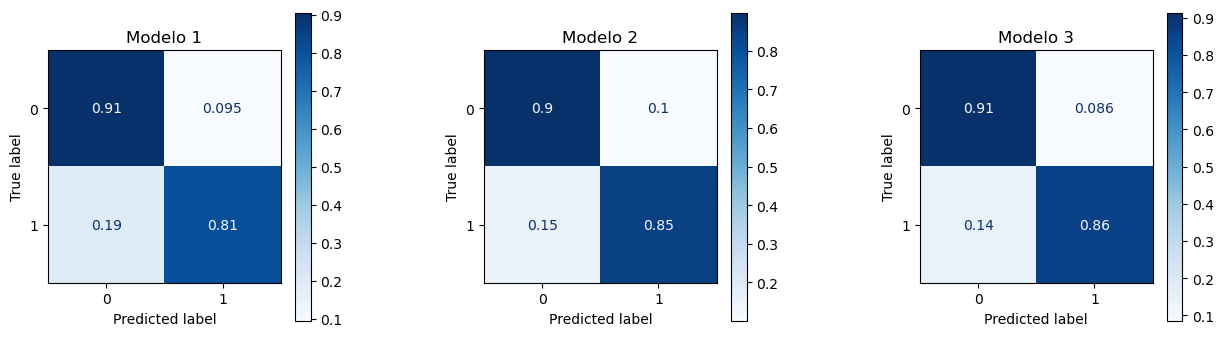

In [40]:
class_labels = test_generator.class_indices.keys()

fig = plt.figure(figsize=(15, 4))
fig.subplots_adjust(wspace=0.5)

plt.subplot(1, 3, 1)
cm_display_model1 = ConfusionMatrixDisplay(confusion_matrix=cm_model1, display_labels=class_labels)
cm_display_model1.plot(cmap='Blues', ax=plt.gca())
plt.title('Modelo 1')

plt.subplot(1, 3, 2)
cm_display_model2 = ConfusionMatrixDisplay(confusion_matrix=cm_model2, display_labels=class_labels)
cm_display_model2.plot(cmap='Blues', ax=plt.gca())
plt.title('Modelo 2')

plt.subplot(1, 3, 3)
cm_display_model3 = ConfusionMatrixDisplay(confusion_matrix=cm_model3, display_labels=class_labels)
cm_display_model3.plot(cmap='Blues', ax=plt.gca())
plt.title('Modelo 3')

plt.show()


## 5.3 Conclusiones

# 6. Ejemplo de predicción en un paciente

# 7. Pipeline end-to-end